{/* cspell:ignore mapsto multigraph inds extrap sharex sharey pidx */}

# Utility-scale error mitigation with probabilistic error amplification
*Usage estimate: 60 minutes on IBM Kyiv (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

The tutorial demonstrates how to run a utility-scale error mitigation experiment with Qiskit Runtime using an experimental version of *zero noise extrapolation* (ZNE) with *probabilistic error amplification* (PEA).

![kim_nature_fig.png](/images/tutorials/utility-scale-error-mitigation-with-probabilistic-error-amplification/e1e67c34-9d4d-4a88-9340-f0b2f3676770.avif)
__Reference__: Y. Kim et al. *Evidence for the utility of quantum computing before fault tolerance.* [Nature 618.7965 (2023)](https://www.nature.com/articles/s41586-023-06096-3)

### Zero-Noise Extrapolation (ZNE)

Zero-noise extrapolation (ZNE) is an error mitigation technique that removes the effects of an *unknown* noise during circuit execution that can be scaled in a *known* way.

It assumes expectation values scale with noise by a known function

$$
\langle A(\lambda) \rangle = \langle A(0) \rangle =+ \sum_{k=0}^{m} a_k \lambda^k + R
$$
where $\lambda$ parameterizes the noise strength and can be amplified.

We can implement ZNE with the following steps:

1. Amplify circuit noise for several noise factors $\lambda_1, \lambda_2, ... $
2. Run every noise-amplified circuit to measure $\langle A(\lambda_1)\rangle, ...$
3. Extrapolate back to the zero-noise limit $\langle A(0)\rangle$


![zne_stages.png](/images/tutorials/utility-scale-error-mitigation-with-probabilistic-error-amplification/5e63d706-82d8-4212-b802-c9191ce53341.avif)

#### Amplify noise for ZNE

The main challenge in successfully implementing ZNE is to have an accurate model for noise in the expectation value and to amplify the noise in a known way.

There are three common ways error amplification is implemented for ZNE.

| **Pulse stretching** | **Gate folding** | **Probabilistic error amplification** |
|-----------|-----------|-----------|
| Scale pulse duration via calibration | Repeat gates in identity cycles $U\mapsto U(U^{-1}U)^{\lambda-1}/2$ | Add noise via sampling Pauli channels |
| ![zne_pulse_stretching.png](/images/tutorials/utility-scale-error-mitigation-with-probabilistic-error-amplification/83188b57-e88f-43a1-a7bd-29327f46ecf5.avif) | ![zne_gate_folding.png](/images/tutorials/utility-scale-error-mitigation-with-probabilistic-error-amplification/e1358d08-2632-4fd2-bf0f-f9384a2d3340.avif) | ![zne_pea.png](/images/tutorials/utility-scale-error-mitigation-with-probabilistic-error-amplification/3d69d5bd-70e5-4eeb-aa02-fc0a62043010.avif) |
| Kandala et al. Nature (2019) | Shultz et al. PRA (2022) | Li & Benjamin PRX (2017) |

For utility-scale experiments, *probabilistic error amplification* (PEA) is the most attractive.
- Pulse stretching assumes gate noise is proportional to duration, which is typically not true. Calibration is also costly.
- Gate folding requires large stretch factors that greatly limit the depth of circuits that can be run.
- PEA can be applied to any circuit that can be run with native noise factor ($\lambda=1$) but requires learning the noise model.

### Learn the noise model for PEA

PEA assumes the same layer-based noise model as *probabilistic error cancellation* (PEC); however, it avoids the sampling overhead that scales exponentially with the circuit noise.

| **Step 1** | **Step 2** | **Step 3** |
|-----------|-----------|-----------|
| Pauli twirl layers of two-qubit gates | Repeat identity pairs of layers and learn the noise | Derive a fidelity (error for each noise channel) |
| ![pec_pauli_twirling.png](/images/tutorials/utility-scale-error-mitigation-with-probabilistic-error-amplification/2eab5ff4-40fa-4a41-9f2c-74f5e22c4643.avif) | ![pec_learn_layer.png](/images/tutorials/utility-scale-error-mitigation-with-probabilistic-error-amplification/8d0d64c3-65ad-4419-8ac9-4ec9633d39a0.avif) | ![pec_curve_fitting.png](/images/tutorials/utility-scale-error-mitigation-with-probabilistic-error-amplification/c51bd42d-2463-4c78-807b-d284ca79296f.avif) |

__Reference__: E. van den Berg, Z. Minev, A. Kandala, and K. Temme, _Probabilistic error cancellation with sparse Pauli-Lindblad models on noisy quantum processors_ [arXiv:2201.09866](https://arxiv.org/abs/2201.09866)

## Requirements

Before starting this tutorial, ensure that you have the following installed:

- Qiskit SDK 1.0 or later with Visualization support (`pip install 'qiskit[visualization]'`)
- Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)

## Setup

In [1]:
from __future__ import annotations
from collections.abc import Sequence
from collections import defaultdict
import numpy as np
import rustworkx
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import CXGate, CZGate, ECRGate
from qiskit.providers import Backend
from qiskit.visualization import plot_error_map
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import PubResult

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

## Step 1: Map classical inputs to a quantum problem

### Create a parameterized Ising model circuit

First, choose a backend to run on. This demonstration runs on a 127-qubit backend, but you can modify this to any backend available to you.

In [2]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

#### Helper functions for circuit construction

Next, create some helper functions to construct the circuits for the Trotterized time evolution of a two-dimensional transverse-field Ising model that adheres to the topology of the backend.

In [3]:
"""Trotter circuit generation"""


def remove_qubit_couplings(
    couplings: Sequence[tuple[int, int]], qubits: Sequence[int] | None = None
) -> list[tuple[int, int]]:
    """Remove qubits from a coupling list.

    Args:
        couplings: A sequence of qubit couplings.
        qubits: Optional, the qubits to remove.

    Returns:
        The input couplings with the specified qubits removed.
    """
    if qubits is None:
        return couplings
    qubits = set(qubits)
    return [edge for edge in couplings if not qubits.intersection(edge)]


def coupling_qubits(
    *couplings: Sequence[tuple[int, int]],
    allowed_qubits: Sequence[int] | None = None,
) -> list[int]:
    """Return a sorted list of all qubits involved in 1 or more couplings lists.

    Args:
        couplings: 1 or more coupling lists.
        allowed_qubits: Optional, the allowed qubits to include. If None all
            qubits are allowed.

    Returns:
        The intersection of all qubits in the couplings and the allowed qubits.
    """
    qubits = set()
    for edges in couplings:
        for edge in edges:
            qubits.update(edge)
    if allowed_qubits is not None:
        qubits = qubits.intersection(allowed_qubits)
    return list(qubits)


def construct_layer_couplings(
    backend: Backend,
) -> list[list[tuple[int, int]]]:
    """Separate a coupling map into disjoint 2-qubit gate layers.

    Args:
        backend: A backend to construct layer couplings for.

    Returns:
        A list of disjoint layers of directed couplings for the input coupling map.
    """
    coupling_graph = backend.coupling_map.graph.to_undirected(
        multigraph=False
    )
    edge_coloring = rustworkx.graph_bipartite_edge_color(coupling_graph)

    layers = defaultdict(list)
    for edge_idx, color in edge_coloring.items():
        layers[color].append(
            coupling_graph.get_edge_endpoints_by_index(edge_idx)
        )
    layers = [sorted(layers[i]) for i in sorted(layers.keys())]

    return layers


def entangling_layer(
    gate_2q: str,
    couplings: Sequence[tuple[int, int]],
    qubits: Sequence[int] | None = None,
) -> QuantumCircuit:
    """Generating a entangling layer for the specified couplings.

    This corresponds to a Trotter layer for a ZZ Ising term with angle Pi/2.

    Args:
        gate_2q: The 2-qubit basis gate for the layer, should be "cx", "cz", or "ecr".
        couplings: A sequence of qubit couplings to add CX gates to.
        qubits: Optional, the physical qubits for the layer. Any couplings involving
            qubits not in this list will be removed. If None the range up to the largest
            qubit in the couplings will be used.

    Returns:
        The QuantumCircuit for the entangling layer.
    """
    # Get qubits and convert to set to order
    if qubits is None:
        qubits = range(1 + max(coupling_qubits(couplings)))
    qubits = set(qubits)

    # Mapping of physical qubit to virtual qubit
    qubit_mapping = {q: i for i, q in enumerate(qubits)}

    # Convert couplings to indices for virtual qubits
    indices = [
        [qubit_mapping[i] for i in edge]
        for edge in couplings
        if qubits.issuperset(edge)
    ]

    # Layer circuit on virtual qubits
    circuit = QuantumCircuit(len(qubits))

    # Get 2-qubit basis gate and pre and post rotation circuits
    gate2q = None
    pre = QuantumCircuit(2)
    post = QuantumCircuit(2)

    if gate_2q == "cx":
        gate2q = CXGate()
        # Pre-rotation
        pre.sdg(0)
        pre.z(1)
        pre.sx(1)
        pre.s(1)
        # Post-rotation
        post.sdg(1)
        post.sxdg(1)
        post.s(1)
    elif gate_2q == "ecr":
        gate2q = ECRGate()
        # Pre-rotation
        pre.z(0)
        pre.s(1)
        pre.sx(1)
        pre.s(1)
        # Post-rotation
        post.x(0)
        post.sdg(1)
        post.sxdg(1)
        post.s(1)
    elif gate_2q == "cz":
        gate2q = CZGate()
        # Identity pre-rotation
        # Post-rotation
        post.sdg([0, 1])
    else:
        raise ValueError(
            f"Invalid 2-qubit basis gate {gate_2q}, should be 'cx', 'cz', or 'ecr'"
        )

    # Add 1Q pre-rotations
    for inds in indices:
        circuit.compose(pre, qubits=inds, inplace=True)

    # Use barriers around 2-qubit basis gate to specify a layer for PEA noise learning
    circuit.barrier()
    for inds in indices:
        circuit.append(gate2q, (inds[0], inds[1]))
    circuit.barrier()

    # Add 1Q post-rotations after barrier
    for inds in indices:
        circuit.compose(post, qubits=inds, inplace=True)

    # Add physical qubits as metadata
    circuit.metadata["physical_qubits"] = tuple(qubits)

    return circuit


def trotter_circuit(
    theta: Parameter | float,
    layer_couplings: Sequence[Sequence[tuple[int, int]]],
    num_steps: int,
    gate_2q: str | None = "cx",
    backend: Backend | None = None,
    qubits: Sequence[int] | None = None,
) -> QuantumCircuit:
    """Generate a Trotter circuit for the 2D Ising

    Args:
        theta: The angle parameter for X.
        layer_couplings: A list of couplings for each entangling layer.
        num_steps: the number of Trotter steps.
        gate_2q: The 2-qubit basis gate to use in entangling layers.
            Can be "cx", "cz", "ecr", or None if a backend is provided.
        backend: A backend to get the 2-qubit basis gate from, if provided
            will override the basis_gate field.
        qubits: Optional, the allowed physical qubits to truncate the
            couplings to. If None the range up to the largest
            qubit in the couplings will be used.

    Returns:
        The Trotter circuit.
    """
    if backend is not None:
        try:
            basis_gates = backend.configuration().basis_gates
        except AttributeError:
            basis_gates = backend.basis_gates
        for gate in ["cx", "cz", "ecr"]:
            if gate in basis_gates:
                gate_2q = gate
                break

    # If no qubits, get the largest qubit from all layers and
    # specify the range so the same one is used for all layers.
    if qubits is None:
        qubits = range(1 + max(coupling_qubits(layer_couplings)))

    # Generate the entangling layers
    layers = [
        entangling_layer(gate_2q, couplings, qubits=qubits)
        for couplings in layer_couplings
    ]

    # Construct the circuit for a single Trotter step
    num_qubits = len(qubits)
    trotter_step = QuantumCircuit(num_qubits)
    trotter_step.rx(theta, range(num_qubits))
    for layer in layers:
        trotter_step.compose(layer, range(num_qubits), inplace=True)

    # Construct the circuit for the specified number of Trotter steps
    circuit = QuantumCircuit(num_qubits)
    for _ in range(num_steps):
        circuit.rx(theta, range(num_qubits))
        for layer in layers:
            circuit.compose(layer, range(num_qubits), inplace=True)

    circuit.metadata["physical_qubits"] = tuple(qubits)
    return circuit

#### Define entangling layer couplings

To implement the Trotterized Ising simulation, define three layers of two-qubit gate couplings for the device, to be repeated at each of the Trotter steps. These define the three twirled layers you need to learn the noise for to implement mitigation.

In [4]:
layer_couplings = construct_layer_couplings(backend)
for i, layer in enumerate(layer_couplings):
    print(f"Layer {i}:\n{layer}\n")

Layer 0:
[(5, 4), (10, 9), (11, 12), (16, 8), (20, 19), (21, 22), (23, 24), (26, 25), (28, 27), (29, 30), (31, 32), (33, 39), (35, 47), (36, 51), (37, 52), (40, 41), (44, 43), (45, 46), (50, 49), (54, 64), (58, 71), (60, 61), (63, 62), (66, 67), (68, 69), (72, 81), (73, 85), (77, 78), (84, 83), (88, 87), (89, 74), (91, 79), (92, 102), (94, 90), (96, 95), (98, 99), (100, 110), (103, 104), (105, 106), (108, 112), (109, 114), (111, 122), (116, 117), (118, 119), (121, 120), (125, 124)]

Layer 1:
[(0, 14), (1, 2), (4, 3), (6, 5), (7, 8), (10, 11), (17, 12), (19, 18), (22, 15), (24, 25), (26, 16), (31, 30), (33, 20), (35, 28), (37, 38), (40, 39), (42, 41), (43, 34), (46, 47), (48, 49), (50, 51), (53, 60), (54, 45), (57, 56), (58, 59), (64, 65), (68, 55), (70, 74), (72, 62), (73, 66), (75, 76), (77, 71), (79, 78), (80, 81), (82, 83), (85, 84), (87, 86), (93, 106), (96, 109), (97, 98), (100, 99), (101, 102), (105, 104), (107, 108), (110, 118), (114, 115), (119, 120), (122, 121), (123, 124), (1

#### Remove bad qubits

Look at the coupling map for the backend and see if any qubits connect to couplings with high error. Remove these "bad" qubits from your experiment.

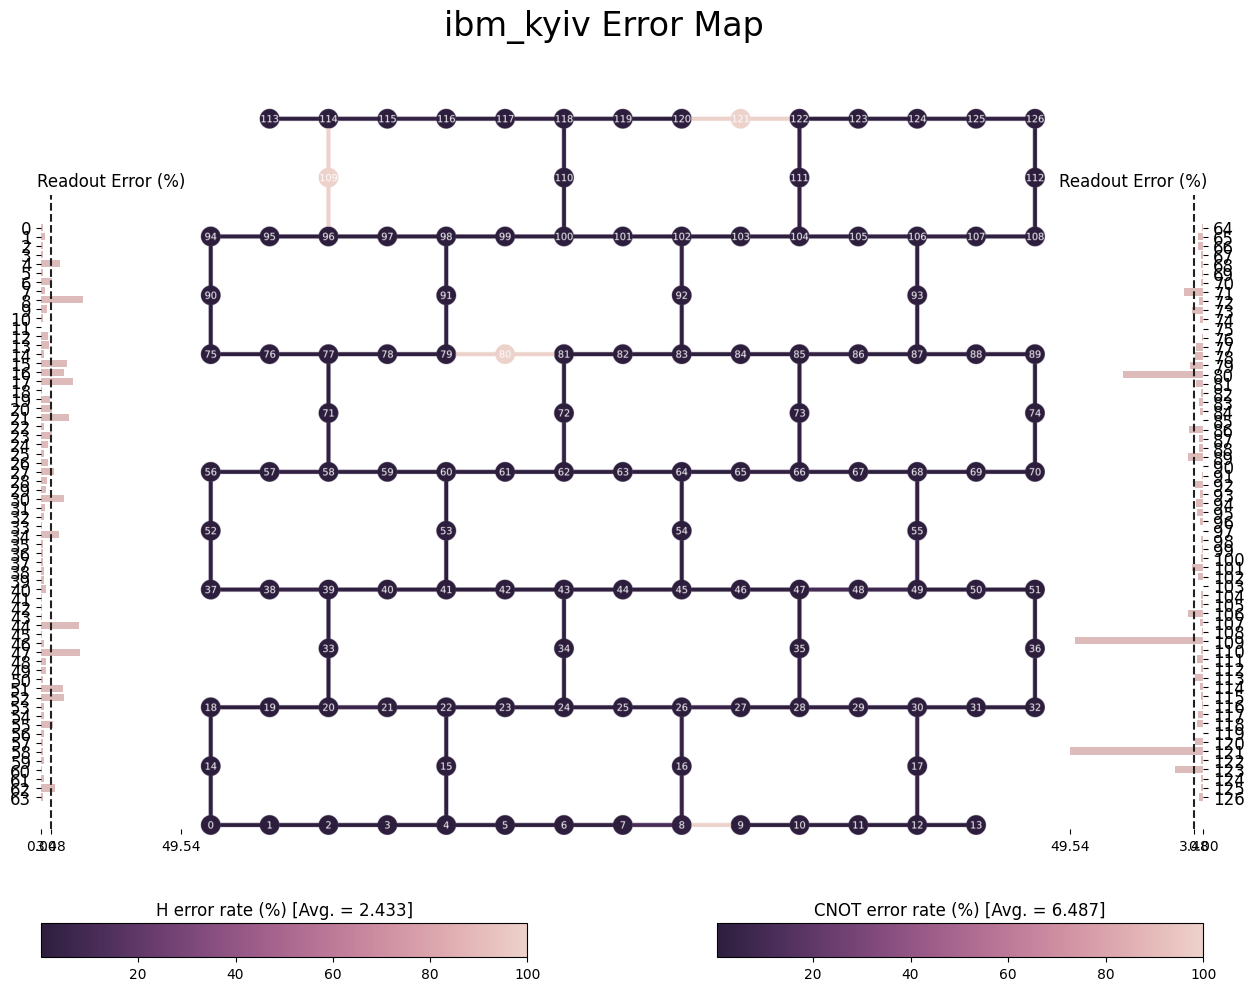

In [5]:
# Plot gate error map
# NOTE: These can change over time, so your results may look different
plot_error_map(backend)

In [6]:
bad_qubits = {
    56,
    63,
    67,
}  # qubits removed based on high coupling error (1.00)
good_qubits = list(set(range(backend.num_qubits)).difference(bad_qubits))
print("Physical qubits:\n", good_qubits)

Physical qubits:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]


#### Main Trotter circuit generation

In [7]:
num_steps = 6
theta = Parameter("theta")
circuit = trotter_circuit(
    theta, layer_couplings, num_steps, qubits=good_qubits, backend=backend
)

### Create a list of parameter values to be assigned later

In [8]:
num_params = 12

# 12 parameter values for Rx between [0, pi/2].
# Reshape to outer product broadcast with observables
parameter_values = np.linspace(0, np.pi / 2, num_params).reshape(
    (num_params, 1)
)
num_params = parameter_values.size

## Step 2: Optimize problem for quantum hardware execution

### ISA circuit

Before running the circuit on hardware, optimize it for hardware execution. This process involves a few steps:

- Pick a qubit layout that maps the virtual qubits of your circuit to physical qubits on the hardware.
- Insert swap gates as needed to route interactions between qubits that are not connected.
- Translate the gates in our circuit to [Instruction Set Architecture (ISA)](https://docs.quantum.ibm.com/transpile#instruction-set-architecture) instructions that can directly be executed on the hardware.
- Perform circuit optimizations to minimize the circuit depth and gate count.

Although the transpiler built into Qiskit can perform all of these steps, this notebook demonstrates building the utility-scale Trotter circuit in a ground-up fashion. Select the good physical qubits and define entangling layers on connected qubit pairs from those selected qubits. Nonetheless, you still need to translate non-ISA gates in the circuit and avail any circuit optimization offered by the transpiler.

Transpile your circuit for the chosen backend by creating a pass manager and then running the pass manager on the circuit. Also, fix the initial layout of the circuit to the already selected `good_qubits`. An easy way to create a pass manager is to use the [`generate_preset_pass_manager`](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) function. See [Transpile with pass managers](https://docs.quantum.ibm.com/transpile/transpile-with-pass-managers) for a more detailed explanation of transpiling with pass managers.

In [9]:
pm = generate_preset_pass_manager(
    backend=backend,
    initial_layout=good_qubits,
    layout_method="trivial",
    optimization_level=1,
)

isa_circuit = pm.run(circuit)

### ISA observables

Next, create all weight-1 $\langle Z \rangle$ observables for each virtual qubit by padding the necessary number of $\langle I \rangle$ terms.

In [10]:
observables = []
num_qubits = len(good_qubits)
for q in range(num_qubits):
    observables.append(
        SparsePauliOp("I" * (num_qubits - q - 1) + "Z" + "I" * q)
    )

The transpilation process has mapped the virtual qubits of your circuit to physical qubits on the hardware. The information about the qubit layout is stored in the `layout` attribute of the transpiled circuit. Your observable is also defined in terms of the virtual qubits, so you need to apply this layout to the observable. This is done using the `apply_layout` method of `SparsePauliOp`.

Notice that each observable is wrapped in a list in the following code block. It is done to _broadcast_ with parameter values so that each qubit observable is measured for each theta value. The broadcasting rules for primitives can be found [here](https://docs.quantum.ibm.com/run/primitives).

In [11]:
isa_observables = [
    [obs.apply_layout(layout=isa_circuit.layout)] for obs in observables
]

## Step 3: Execute using Qiskit primitives

In [12]:
pub = (isa_circuit, isa_observables, parameter_values)

### Configure Estimator options

Next configure the `Estimator` options needed to run the mitigation experiment. This includes options for the noise learning of the entangling layers, and for ZNE extrapolation.

We use the following configuration:

In [13]:
# Experiment options
num_randomizations = 700
num_randomizations_learning = 40
max_batch_circuits = 3 * num_params
shots_per_randomization = 64
learning_pair_depths = [0, 1, 2, 4, 6, 12, 24]
noise_factors = [1, 1.3, 1.6]
extrapolated_noise_factors = np.linspace(0, max(noise_factors), 20)

# Base option formatting
options = {
    # Builtin resilience settings for ZNE
    "resilience": {
        "measure_mitigation": True,
        "zne_mitigation": True,
        # TREX noise learning configuration
        "measure_noise_learning": {
            "num_randomizations": num_randomizations_learning,
            "shots_per_randomization": 1024,
        },
        # PEA noise model configuration
        "layer_noise_learning": {
            "max_layers_to_learn": 3,
            "layer_pair_depths": learning_pair_depths,
            "shots_per_randomization": shots_per_randomization,
            "num_randomizations": num_randomizations_learning,
        },
        "zne": {
            "amplifier": "pea",
            "noise_factors": noise_factors,
            "extrapolator": ("exponential", "linear"),
            "extrapolated_noise_factors": extrapolated_noise_factors.tolist(),
        },
    },
    # Randomization configuration
    "twirling": {
        "num_randomizations": num_randomizations,
        "shots_per_randomization": shots_per_randomization,
        "strategy": "active-circuit",
    },
    # Optional Dynamical Decoupling (DD)
    "dynamical_decoupling": {"enable": True, "sequence_type": "XY4"},
}

#### Explanation of ZNE options

The following gives details on the additional options in the experimental branch. Note that these options and names are not finalized, and everything here is subject to change before an official release.

* __amplifier__: The method to use when amplifying noise to the intended noise factors.
    Allowed values are `"gate_folding"`, which amplifies by repeating two-qubit basis gates,
    and `"pea"`, which amplifies by probabilistic sampling after learning the Pauli-twirled
    noise model for layers of twirled two-qubit basis gates. There are also `"gate_folding_front"` and `"gate_folding_back"` options which are explained in the [API documentation](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/options-zne-options#amplifier)
* __extrapolated_noise_factors__: Specify one or more noise factor values at which to evaluate the
    extrapolated models. If a sequence of values, the returned results will be array-valued with specified noise factor evaluated for the extrapolation model. A value
    of 0 corresponds to zero-noise extrapolation.

### Run the experiment

In [42]:
estimator = Estimator(mode=backend, options=options)
job = estimator.run([pub])

In [45]:
print(f"Job ID {job.job_id()}")

Job ID czz64rbd8drg008j141g


## Step 4: Post-process and return result in desired classical format

Once the experiment is finished, you can view our results. You fetch the raw and mitigated expectation values and compare them with exact results. Then, plot the expectation values, both mitigated (extrapolated) and raw, averaged over all qubits for each parameter. Finally, plot expectation values for your choice of individual qubits.

In [15]:
primitive_result = job.result()

### General result shapes and metadata

The `PrimitiveResult` object contains a list-like structure named `PubResult`. As we submit only one PUB to the estimator, the `PrimitiveResult` contains a single `PubResult` object.

The PUB (primitive unified bloc) result expectation values and standard errors are array-valued. For estimator jobs with ZNE, there are several data fields of expectation values and standard errors available in the `PubResult`'s `DataBin` container. We will breifly discuss the data fields for expectation values here (similar data fields are available for standard errors (`stds`) as well).

1. `pub_result.data.evs`: Expectation values corresponding to the zero noise (based on heuristically best extrapolation).
    - The first axis is the virtual qubit index for observable $\langle Z_i\rangle$ ($124$ virtual-qubits/observables)
    - The second axis indexes the parameter value for $\theta$ ($12$ parameter values)
2. `pub_result.data.evs_extrapolated`: Expectation values for extrapolated noise factors for every extrapolator. This array has two additional axes.
    - The third axis indexes the extrapolation methods ($2$ extrapolators, `exponential` and `linear`)
    - The last axis indexes the `extrapolated_noise_factors` ($20$ extrapolation points specifed in the option)
3. `pub_result.data.evs_noise_factors`: Raw expectation values for each noise factor.
   - The third axis indexes the raw `noise_factors` ($3$ factors)

In [16]:
pub_result = primitive_result[0]

print(
    f"{pub_result.data.evs.shape=}\n"
    f"{pub_result.data.evs_extrapolated.shape=}\n"
    f"{pub_result.data.evs_noise_factors.shape=}\n"
)

pub_result.data.evs.shape=(124, 12)
pub_result.data.evs_extrapolated.shape=(124, 12, 2, 20)
pub_result.data.evs_noise_factors.shape=(124, 12, 3)



Several metadata fields are also available in the `PrimitiveResult`. The metadata includes
- `resilience/zne/noise_factors`: The raw noise factors
- `resilience/zne/extrapolator`: The extrapolators used for each result

In [17]:
primitive_result.metadata

{'dynamical_decoupling': {'enable': True,
  'sequence_type': 'XY4',
  'extra_slack_distribution': 'middle',
  'scheduling_method': 'alap'},
 'twirling': {'enable_gates': True,
  'enable_measure': True,
  'num_randomizations': 700,
  'shots_per_randomization': 64,
  'interleave_randomizations': True,
  'strategy': 'active-circuit'},
 'resilience': {'measure_mitigation': True,
  'zne_mitigation': True,
  'pec_mitigation': False,
  'zne': {'noise_factors': [1, 1.3, 1.6],
   'extrapolator': ['exponential', 'linear'],
   'extrapolated_noise_factors': [0,
    0.08421052631578947,
    0.16842105263157894,
    0.25263157894736843,
    0.3368421052631579,
    0.42105263157894735,
    0.5052631578947369,
    0.5894736842105263,
    0.6736842105263158,
    0.7578947368421053,
    0.8421052631578947,
    0.9263157894736842,
    1.0105263157894737,
    1.0947368421052632,
    1.1789473684210525,
    1.263157894736842,
    1.3473684210526315,
    1.431578947368421,
    1.5157894736842106,
    1.6]},

The `PubResult` object has additional resilience metadata about the learned noise models used in mitigation.

In [18]:
# Print learned layer noise metadata
for field, value in pub_result.metadata["resilience"]["layer_noise"].items():
    print(f"{field}: {value}")

noise_overhead: Infinity
total_mitigated_layers: 18
unique_mitigated_layers: 3
unique_mitigated_layers_noise_overhead: [3.791143096348365e+26, 3.3275292822235375e+53, 7422.268372344261]


In [19]:
# Exact data computed using the methods described in the original reference
# Y. Kim et al. "Evidence for the utility of quantum computing before fault tolerance" (Nature 618, 500–505 (2023))
# Directly used here for brevity
exact_data = np.array(
    [
        1,
        0.9899,
        0.9531,
        0.8809,
        0.7536,
        0.5677,
        0.3545,
        0.1607,
        0.0539,
        0.0103,
        0.0012,
        0.0,
    ]
)

### Plot Trotter simulation results

The following code creates a plot to compare the raw and mitigated experiment results against the exact solution.

In [20]:
"""Result visualization functions"""


def plot_trotter_results(
    pub_result: PubResult,
    angles: Sequence[float],
    plot_noise_factors: Sequence[float] | None = None,
    plot_extrapolator: Sequence[str] | None = None,
    exact: np.ndarray = None,
    close: bool = True,
):
    """Plot average magnetization from ZNE result data.
    Args:
        pub_result: The Estimator PubResult for the PEA experiment.
        angles: The Rx angle values for the experiment.
        plot_raw: If provided plot the unextrapolated data for the noise factors.
        plot_extrapolator: If provided plot all extrapolators, if False only plot
            the Automatic method.
        exact: Optional, the exact values to include in the plot. Should be a 1D
            array-like where the values represent exact magnetization.
        close: Close the Matplotlib figure before returning.
    Returns:
        The figure.
    """
    data = pub_result.data

    evs = data.evs
    num_qubits = evs.shape[0]
    num_params = evs.shape[1]
    angles = np.asarray(angles).ravel()
    if angles.shape != (num_params,):
        raise ValueError(
            f"Incorrect number of angles for input data {angles.size} != {num_params}"
        )

    # Take average magnetization of qubits and its standard error
    x_vals = angles / np.pi
    y_vals = np.mean(evs, axis=0)
    y_errs = np.std(evs, axis=0) / np.sqrt(num_qubits)

    fig, _ = plt.subplots(1, 1)

    # Plot auto method
    plt.errorbar(x_vals, y_vals, y_errs, fmt="o-", label="ZNE (automatic)")

    # Plot individual extrapolator results
    if plot_extrapolator:
        y_vals_extrap = np.mean(data.evs_extrapolated, axis=0)
        y_errs_extrap = np.std(data.evs_extrapolated, axis=0) / np.sqrt(
            num_qubits
        )
        for i, extrap in enumerate(plot_extrapolator):
            plt.errorbar(
                x_vals,
                y_vals_extrap[:, i, 0],
                y_errs_extrap[:, i, 0],
                fmt="s-.",
                alpha=0.5,
                label=f"ZNE ({extrap})",
            )

    # Plot raw results
    if plot_noise_factors:
        y_vals_raw = np.mean(data.evs_noise_factors, axis=0)
        y_errs_raw = np.std(data.evs_noise_factors, axis=0) / np.sqrt(
            num_qubits
        )
        for i, nf in enumerate(plot_noise_factors):
            plt.errorbar(
                x_vals,
                y_vals_raw[:, i],
                y_errs_raw[:, i],
                fmt="d:",
                alpha=0.5,
                label=f"Raw (nf={nf:.1f})",
            )

    # Plot exact data
    if exact is not None:
        plt.plot(x_vals, exact, "--", color="black", alpha=0.5, label="Exact")

    plt.ylim(-0.1, 1.2)
    plt.xlabel("θ/π")
    plt.ylabel(r"$\overline{\langle Z \rangle}$")
    plt.legend()
    plt.title(
        f"Error Mitigated Average Magnetization for Rx(θ) [{num_qubits}-qubit]"
    )
    if close:
        plt.close(fig)
    return fig

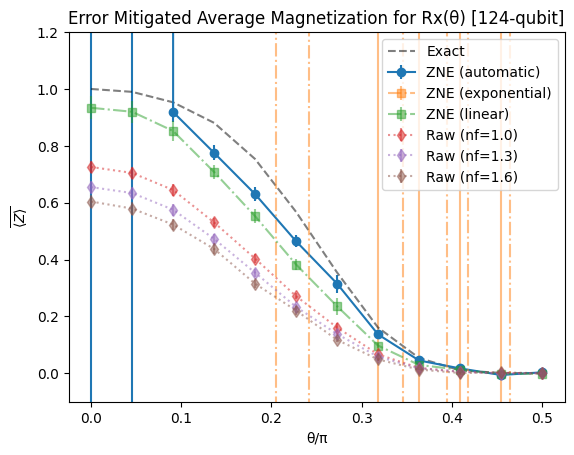

In [21]:
zne_metadata = primitive_result.metadata["resilience"]["zne"]
# Plot Trotter simulation results
fig = plot_trotter_results(
    pub_result,
    parameter_values,
    plot_extrapolator=zne_metadata["extrapolator"],
    plot_noise_factors=zne_metadata["noise_factors"],
    exact=exact_data,
)
display(fig)

While the noisy (noise factor `nf=1.0`) values show high deviation from exact values, the mitigated values are close to exact values, demonstrating the utility of the PEA-based mitigation technique.

### Plot extrapolation results for individual qubits

Finally, the following code creates a plot to show the extrapolation curves for different values of theta on a specific qubit.

In [22]:
def plot_qubit_zne_data(
    pub_result: PubResult,
    angles: Sequence[float],
    qubit: int,
    noise_factors: Sequence[float],
    extrapolator: Sequence[str] | None = None,
    extrapolated_noise_factors: Sequence[float] | None = None,
    num_cols: int | None = None,
    close: bool = True,
):
    """Plot ZNE extrapolation data for specific virtual qubit
    Args:
        pub_result: The Estimator PubResult for the PEA experiment.
        angles: The Rx theta angles used for the experiment.
        qubit: The virtual qubit index to plot.
        noise_factors: the raw noise factors.
        extrapolator: The extrapolator metadata for multiple extrapolators.
        extrapolated_noise_factors: The noise factors used for extrapolation.
        num_cols: The number of columns for the generated subplots.
        close: Close the Matplotlib figure before returning.
    Returns:
        The Matplotlib figure.
    """
    data = pub_result.data

    evs_auto = data.evs[qubit]
    stds_auto = data.stds[qubit]
    evs_extrap = data.evs_extrapolated[qubit]
    stds_extrap = data.stds_extrapolated[qubit]
    evs_raw = data.evs_noise_factors[qubit]
    stds_raw = data.stds_noise_factors[qubit]

    num_params = evs_auto.shape[0]
    angles = np.asarray(angles).ravel()
    if angles.shape != (num_params,):
        raise ValueError(
            f"Incorrect number of angles for input data {angles.size} != {num_params}"
        )

    # Make a square subplot
    num_cols = num_cols or int(np.ceil(np.sqrt(num_params)))
    num_rows = int(np.ceil(num_params / num_cols))
    fig, axes = plt.subplots(
        num_rows, num_cols, sharex=True, sharey=True, figsize=(12, 5)
    )
    fig.suptitle(f"ZNE data for virtual qubit {qubit}")

    for pidx, ax in zip(range(num_params), axes.flat):
        # Plot auto extrapolated
        ax.errorbar(
            0,
            evs_auto[pidx],
            stds_auto[pidx],
            fmt="o",
            label="PEA (automatic)",
        )

        # Plot extrapolators
        if (
            extrapolator is not None
            and extrapolated_noise_factors is not None
        ):
            for i, method in enumerate(extrapolator):
                ax.errorbar(
                    extrapolated_noise_factors,
                    evs_extrap[pidx, i],
                    stds_extrap[pidx, i],
                    fmt="-",
                    alpha=0.5,
                    label=f"PEA ({method})",
                )

        # Plot raw
        ax.errorbar(
            noise_factors, evs_raw[pidx], stds_raw[pidx], fmt="d", label="Raw"
        )

        ax.set_yticks([0, 0.5, 1, 1.5, 2])
        ax.set_ylim(0, max(1, 1.1 * max(evs_auto)))

        ax.set_xticks([0, *noise_factors])
        ax.set_title(f"θ/π = {angles[pidx]/np.pi:.2f}")
        if pidx == 0:
            ax.set_ylabel(r"$\langle Z_{" + str(qubit) + r"} \rangle$")
        if pidx == num_params - 1:
            ax.set_xlabel("Noise Factor")
            ax.legend()
    if close:
        plt.close(fig)
    return fig

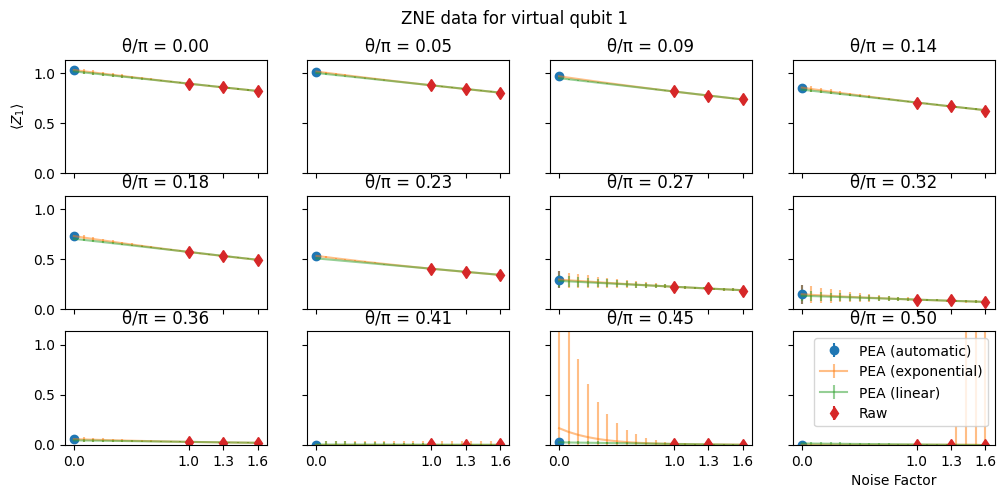

In [23]:
virtual_qubit = 1
plot_qubit_zne_data(
    pub_result=pub_result,
    angles=parameter_values,
    qubit=virtual_qubit,
    noise_factors=zne_metadata["noise_factors"],
    extrapolator=zne_metadata["extrapolator"],
    extrapolated_noise_factors=zne_metadata["extrapolated_noise_factors"],
)

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_9z7nltLeb5cX9Cm)

© IBM Corp. 2024